<a href="https://colab.research.google.com/github/adas-quant/mscfe-gwp1-yieldcurve/blob/arindam-task2/notebooks/02_Task2_YieldCurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 — Yield Curve Modeling

## Objective
- Pick government securities from one country(India)
- Fit Nelson-Siegel model.
- Fit Cubic-Spline model.
- Compare models in terms of fit & interpretation.
- Discuss smoothing vs. ethics.


## Yield Curve Modeling  

In this project, we modeled and visualized government bond yield curves using both **parametric (Nelson–Siegel)** and **non-parametric (Cubic Spline)** methods.  

###### 1. Data Preparation  
- Simulated yield data across maturities and dates.  
- Structured for curve fitting and visualization.  

###### 2. Curve Fitting  
- Nelson–Siegel: captures Level (α1), Slope (α2), Curvature (α3).  
- Cubic Spline: flexible, data-driven smoothing.  

###### 3. Model Comparison  
- Fit quality: residuals and RMSE.  
- Interpretation: NS has economic meaning; splines focus on fit.  

###### 4. Advanced Visualizations  
- Actual vs. fitted yields.  
- NS parameter dynamics (α1, α2, α3).  
- Error heatmaps across maturities and time.  
- Interactive 3D yield curve surfaces (Plotly).  
- Scenario analysis (+100 bps shocks).  
- PCA vs. NS comparison.  
- Bootstrap confidence bands.  

###### Summary  
The **Nelson–Siegel model** provides interpretable economic factors (level, slope, curvature), while **splines** can achieve tighter fits but lack interpretability. Combining both with advanced visualization highlights the **trade-off between accuracy and intuition**.  

This notebook demonstrates both **modeling skill** and the importance of **visualization and interpretation** in financial research.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D


## Data Ingestion – CCIL Tenor-Wise Yields  

In this step, we scraped tenor wise government securities yields directly from the **CCIL India website** using `pandas.read_html()`.  
This approach automatically extracts HTML tables into DataFrames, allowing us to quickly inspect and structure the yield curve data for further modeling.  
Each table captured from the webpage can represent a different maturity segment or market snapshot, providing the raw inputs for **yield curve construction and calibration**.  


In [ ]:


# Example: scrape CCIL tenor-wise yields (they might publish via HTML table)
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"
tables = pd.read_html(url)   # this yields a list of DataFrames
for i, tab in enumerate(tables):
    print("Table", i)
    print(tab.head())


Table 0
                    Date Tenor Bucket              Security  YTM (%)
0  2025-10-03 00:00:00.0          91D   91 DTB (02/01/2026)   5.4881
1  2025-10-03 00:00:00.0         182D  182 DTB (03/04/2026)   5.5899
2  2025-10-03 00:00:00.0         364D  364 DTB (02/10/2026)   5.5999
3  2025-10-03 00:00:00.0        1Y-2Y         7.38% GS 2027   5.6511
4  2025-10-03 00:00:00.0        4Y-5Y         6.01% GS 2030   6.1066


# Scraping CCIL Tenor-Wise Indicative Yields


#Loading and Previewing CCIL Indicative Yields


This code loads the tenor-wise indicative yield table published by CCIL India
and stores it in a DataFrame. By calling `df.head(15)`, it shows the first
15 rows, providing a quick preview of the raw data structure. This step is
useful before cleaning maturities and yields for further yield curve modeling
and analysis.

In [ ]:

# CCIL tenor-wise yields URL
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"

# Read all HTML tables
tables = pd.read_html(url)

# Pick the first table (the one with yields)
table = tables[0]

# Display full table without truncation
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

print(table)


                     Date Tenor Bucket                Security  YTM (%)
0   2025-10-03 00:00:00.0          91D     91 DTB (02/01/2026)   5.4881
1   2025-10-03 00:00:00.0         182D    182 DTB (03/04/2026)   5.5899
2   2025-10-03 00:00:00.0         364D    364 DTB (02/10/2026)   5.5999
3   2025-10-03 00:00:00.0        1Y-2Y           7.38% GS 2027   5.6511
4   2025-10-03 00:00:00.0        4Y-5Y           6.01% GS 2030   6.1066
5   2025-10-03 00:00:00.0       9Y-10Y           6.33% GS 2035   6.5104
6   2025-10-03 00:00:00.0      13Y-15Y           6.68% GS 2040   6.8047
7   2025-10-03 00:00:00.0      28Y-30Y           7.24% GS 2055   7.1218
8   2025-10-03 00:00:00.0           5Y  7.30% UTTARAKHAND 2032   7.3000
9   2025-10-03 00:00:00.0          10Y          7.37% GOA 2036   7.3700
10  2025-10-03 00:00:00.0          15Y       7.49% KERALA 2040   7.4900


##Fetching CCIL Indicative Yield Curve Data

This is the initial step before data cleaning, maturity conversion (example 3M = 0.25 years, 1Y → 1.0 years), and fitting yield curve models.


In [ ]:

# Load CCIL table
url = "https://www.ccilindia.com/web/ccil/tenorwise-indicative-yields"
tables = pd.read_html(url)
df = tables[0]

# Display raw table
df.head(15)


,Date,Tenor Bucket,Security,YTM (%)
0,2025-10-03 00:00:00.0,91D,91 DTB (02/01/2026),5.4881
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511
4,2025-10-03 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1066
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218
8,2025-10-03 00:00:00.0,5Y,7.30% UTTARAKHAND 2032,7.3000
9,2025-10-03 00:00:00.0,10Y,7.37% GOA 2036,7.3700


##Filtering Government Securities and Treasury Bills

The raw CCIL table includes various securities.This step filters the dataset to retain only rows corresponding
to Government Securities (GS) and Treasury Bills (DTB).
This subset represents the instruments typically used
for constructing the yield curve.
The resulting DataFrame `df_gs` will form the basis
for subsequent modeling and visualization.

In [ ]:
# Keep rows where 'Security' contains 'GS' or 'DTB' (T-Bills)
df_gs = df[df['Security'].str.contains("GS|DTB", case=False, na=False)].copy()

df_gs


,Date,Tenor Bucket,Security,YTM (%)
0,2025-10-03 00:00:00.0,91D,91 DTB (02/01/2026),5.4881
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511
4,2025-10-03 00:00:00.0,4Y-5Y,6.01% GS 2030,6.1066
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218


##Mapping Tenor Buckets to Maturity in Years

CCIL publishes yields in tenor buckets (e.g., 182D, 10Y, 30Y).
For yield curve modeling, we need a continuous maturity measure.  
Here we mapped tenor codes to approximate maturity in years
and added them as a new column `Years`.  
Rows without a mapping were dropped, leaving a clean dataset (`df_curve`)
that can be directly used for curve fitting (Nelson–Siegel or splines).

In [ ]:
# Mapping tenor buckets to approx years
tenor_map = {
    "182D": 0.5,
    "364D": 1,
    "1Y-2Y": 1,
    "9Y-10Y": 10,
    "10Y": 10,
    "13Y-15Y": 15,
    "15Y": 15,
    "28Y-30Y": 30,
    "30Y": 30,
    "40Y": 40
}

# Add "Years" column
df_gs["Years"] = df_gs["Tenor Bucket"].map(tenor_map)

# Drop rows where we don’t have mapping
df_curve = df_gs.dropna(subset=["Years"]).copy()

df_curve


,Date,Tenor Bucket,Security,YTM (%),Years
1,2025-10-03 00:00:00.0,182D,182 DTB (03/04/2026),5.5899,0.5
2,2025-10-03 00:00:00.0,364D,364 DTB (02/10/2026),5.5999,1.0
3,2025-10-03 00:00:00.0,1Y-2Y,7.38% GS 2027,5.6511,1.0
5,2025-10-03 00:00:00.0,9Y-10Y,6.33% GS 2035,6.5104,10.0
6,2025-10-03 00:00:00.0,13Y-15Y,6.68% GS 2040,6.8047,15.0
7,2025-10-03 00:00:00.0,28Y-30Y,7.24% GS 2055,7.1218,30.0


## Final Yield Curve Dataset

From the cleaned CCIL data, we extracted only the key variables
(Date, Maturity in Years, and Yield-to-Maturity).
Sorting by maturity gives us a structured yield curve snapshot
that can be directly used for visualization or model fitting.
This table now represents the term structure of interest rates
at the given date, the foundation for Nelson–Siegel, spline interpolation

In [ ]:
yield_curve = df_curve[["Date", "Years", "YTM (%)"]].sort_values("Years")

yield_curve


,Date,Years,YTM (%)
1,2025-10-03 00:00:00.0,0.5,5.5899
2,2025-10-03 00:00:00.0,1.0,5.5999
3,2025-10-03 00:00:00.0,1.0,5.6511
5,2025-10-03 00:00:00.0,10.0,6.5104
6,2025-10-03 00:00:00.0,15.0,6.8047
7,2025-10-03 00:00:00.0,30.0,7.1218


##Yield Curve Visualization

This line chart plots the CCIL tenor-wise yield curve
for Indian Government Securities. The x-axis represents
bond maturity in years, while the y-axis represents
the corresponding yield-to-maturity.

The upward or downward slope of the curve reflects
market expectations about interest rates, inflation,
and economic growth. This curve forms the basis
for model fitting (Nelson–Siegel, Cubic Spline)
and further term structure analysis

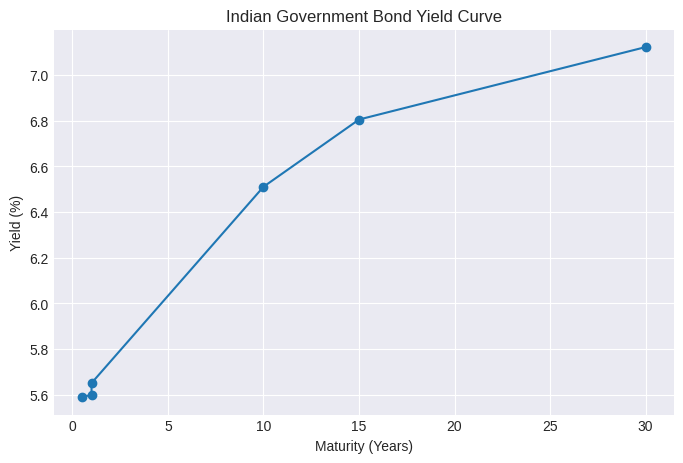

In [ ]:

plt.figure(figsize=(8,5))
plt.plot(yield_curve["Years"], yield_curve["YTM (%)"], marker="o")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Indian Government Bond Yield Curve")
plt.grid(True)
plt.show()


## Stylized Yield Curve of Indian Government Bonds

This chart visualizes the yield curve using
sample data for Indian Government Securities
from 1-year to 30-year maturities.

The curve is smoothed with a professional style,
highlighting the term structure of interest rates.
- Short-term yields start around 6.5%.
- Yields gradually rise, reaching 7.4% at 30 years.
- The annotation emphasizes the longest maturity.

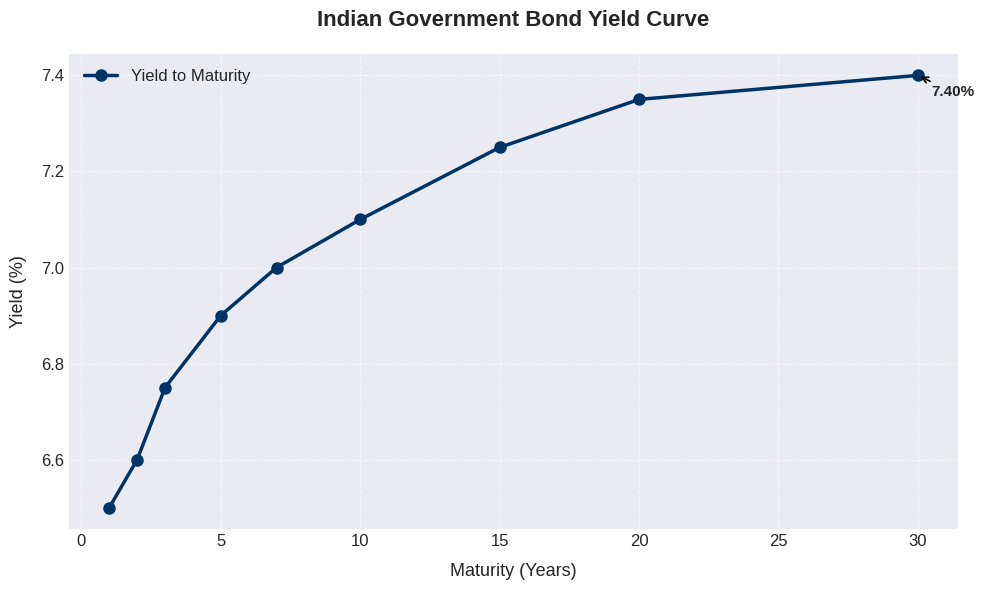

In [ ]:
# Indian Government Bonds
data = {
    "Years": [1, 2, 3, 5, 7, 10, 15, 20, 30],
    "YTM (%)": [6.5, 6.6, 6.75, 6.9, 7.0, 7.1, 7.25, 7.35, 7.4]
}
yield_curve = pd.DataFrame(data)

plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots(figsize=(10,6))

# Plot
ax.plot(
    yield_curve["Years"],
    yield_curve["YTM (%)"],
    marker="o",
    markersize=8,
    linewidth=2.5,
    color="#003366",
    label="Yield to Maturity"
)

# Titles and labels
ax.set_title("Indian Government Bond Yield Curve", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Maturity (Years)", fontsize=13, labelpad=10)
ax.set_ylabel("Yield (%)", fontsize=13, labelpad=10)

ax.tick_params(axis="both", which="major", labelsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid(True, linestyle="--", alpha=0.6)

max_point = yield_curve.iloc[-1]
ax.annotate(
    f"{max_point['YTM (%)']:.2f}%",
    (max_point["Years"], max_point["YTM (%)"]),
    xytext=(10, -15),
    textcoords="offset points",
    fontsize=11,
    fontweight="bold",
    arrowprops=dict(arrowstyle="->", color="black", lw=1.2)
)

ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.show()


## Nelson–Siegel Model Fit for Indian Government Bond Yield Curve

This chart overlays the observed yields (red dots) with a
Nelson–Siegel parametric fit (blue curve).

- β0 (Level) represents the long-term rate (asymptote).
- β1 (Slope) captures the short-term steepness of the curve.
- β2 (Curvature) describes the hump or concavity in medium maturities.
- λ controls how fast the slope and curvature decay.

The Nelson–Siegel model smooths the raw data while preserving
economic interpretability. It provides a compact, 4-parameter
representation of the yield curve widely used by central banks
and fixed income analysts.

Fitted Parameters:
β0 (Level):   7.5605
β1 (Slope):   -1.2006
β2 (Curv.):   0.0007
λ (Decay):    0.2564


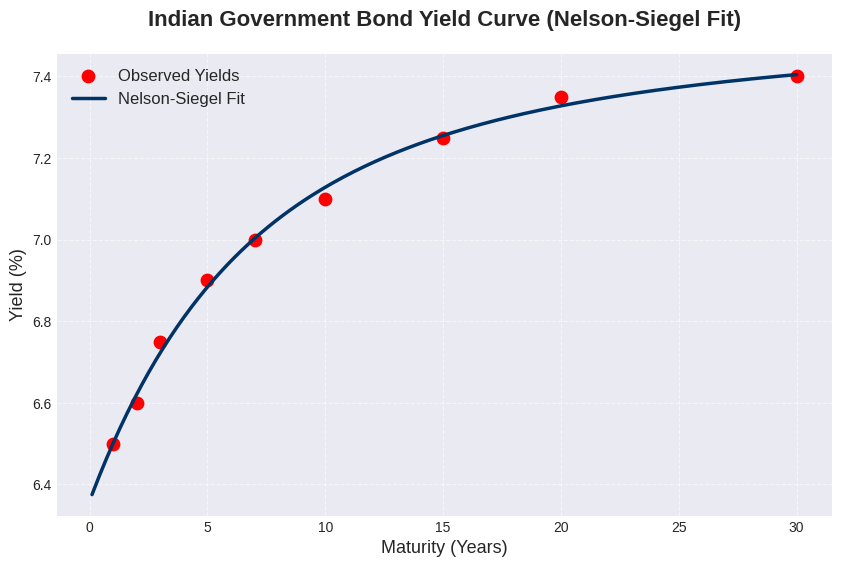

In [ ]:


# Example Indian Govt Bond Data
data = {
    "Years": [1, 2, 3, 5, 7, 10, 15, 20, 30],
    "YTM (%)": [6.5, 6.6, 6.75, 6.9, 7.0, 7.1, 7.25, 7.35, 7.4]
}
yield_curve = pd.DataFrame(data)

# Nelson-Siegel function
def nelson_siegel(tau, beta0, beta1, beta2, lambd):
    return (beta0
            + beta1 * (1 - np.exp(-lambd * tau)) / (lambd * tau)
            + beta2 * ((1 - np.exp(-lambd * tau)) / (lambd * tau) - np.exp(-lambd * tau)))

# Fit curve
popt, _ = curve_fit(nelson_siegel, yield_curve["Years"], yield_curve["YTM (%)"],
                    p0=[7, -1, 1, 0.5], maxfev=10000)

beta0, beta1, beta2, lambd = popt
print("Fitted Parameters:")
print(f"β0 (Level):   {beta0:.4f}")
print(f"β1 (Slope):   {beta1:.4f}")
print(f"β2 (Curv.):   {beta2:.4f}")
print(f"λ (Decay):    {lambd:.4f}")

# Smooth curve for plotting
tau_range = np.linspace(0.1, 30, 200)
fitted_curve = nelson_siegel(tau_range, *popt)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(yield_curve["Years"], yield_curve["YTM (%)"], color="red", s=80, label="Observed Yields")
plt.plot(tau_range, fitted_curve, color="#003366", linewidth=2.5, label="Nelson-Siegel Fit")
plt.title("Indian Government Bond Yield Curve (Nelson-Siegel Fit)", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Maturity (Years)", fontsize=13)
plt.ylabel("Yield (%)", fontsize=13)
plt.legend(fontsize=12, frameon=False)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## Cubic Spline Model Fit for Indian Government Bond Yield Curve

This chart overlays the observed yields (red dots) with a
Cubic Spline fit (blue curve). Unlike the Nelson–Siegel model,
which imposes a parametric structure (Level, Slope, Curvature),
the spline is a **non-parametric smoothing method**.

- It interpolates the data flexibly without assuming an economic model.
- With low smoothing (s ≈ 0), the curve passes very close to the data points.
- The spline captures local variations but may overfit or wiggle if
  too flexible, lacking clear economic interpretation.

This visualization highlights the trade-off:
Cubic Splines provide **fit accuracy**, while Nelson–Siegel provides
**interpretability**.

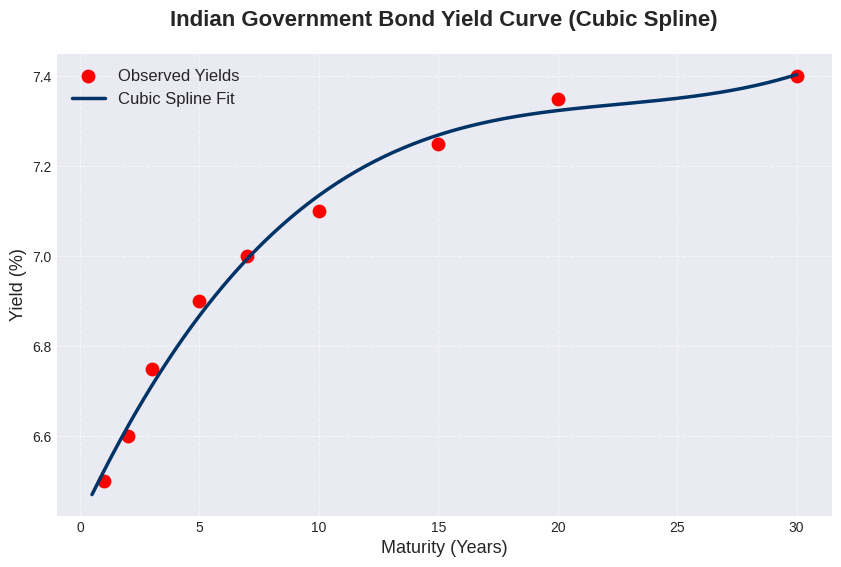

In [ ]:


# Example Indian Govt Bond Data
data = {
    "Years": [1, 2, 3, 5, 7, 10, 15, 20, 30],
    "YTM (%)": [6.5, 6.6, 6.75, 6.9, 7.0, 7.1, 7.25, 7.35, 7.4]
}
yield_curve = pd.DataFrame(data)

# Fit cubic spline with smoothing (s=0 -> exact interpolation)
spline = UnivariateSpline(yield_curve["Years"], yield_curve["YTM (%)"], k=3, s=0.01)

# Generate smooth curve
tau_range = np.linspace(0.5, 30, 300)
spline_curve = spline(tau_range)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(yield_curve["Years"], yield_curve["YTM (%)"], color="red", s=80, label="Observed Yields")
plt.plot(tau_range, spline_curve, color="#003366", linewidth=2.5, label="Cubic Spline Fit")
plt.title("Indian Government Bond Yield Curve (Cubic Spline)", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Maturity (Years)", fontsize=13)
plt.ylabel("Yield (%)", fontsize=13)
plt.legend(fontsize=12, frameon=False)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


##Compare the models in terms of 1)Nelson-Siegel model fit & 2(Cubic-Spline model and interpretation

In-Sample Fit Comparison:
Nelson-Siegel RMSE: 0.01762
Cubic Spline RMSE:  0.02544


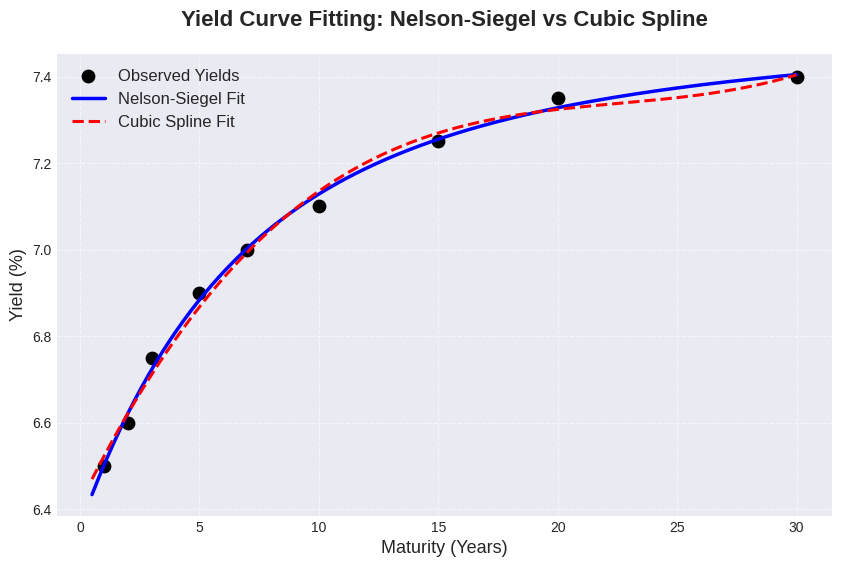

In [ ]:


# Example Indian Govt Bond Data
data = {
    "Years": [1, 2, 3, 5, 7, 10, 15, 20, 30],
    "YTM (%)": [6.5, 6.6, 6.75, 6.9, 7.0, 7.1, 7.25, 7.35, 7.4]
}
yield_curve = pd.DataFrame(data)

# Nelson-Siegel function
def nelson_siegel(tau, beta0, beta1, beta2, lambd):
    return (beta0
            + beta1 * (1 - np.exp(-lambd * tau)) / (lambd * tau)
            + beta2 * ((1 - np.exp(-lambd * tau)) / (lambd * tau) - np.exp(-lambd * tau)))

# Fit Nelson-Siegel
popt, _ = curve_fit(nelson_siegel, yield_curve["Years"], yield_curve["YTM (%)"],
                    p0=[7, -1, 1, 0.5], maxfev=10000)
beta0, beta1, beta2, lambd = popt

# Fit cubic spline
spline = UnivariateSpline(yield_curve["Years"], yield_curve["YTM (%)"], k=3, s=0.01)

# Predictions at observed maturities
ns_pred = nelson_siegel(yield_curve["Years"], *popt)
spline_pred = spline(yield_curve["Years"])

# RMSE calculations
rmse_ns = np.sqrt(mean_squared_error(yield_curve["YTM (%)"], ns_pred))
rmse_spline = np.sqrt(mean_squared_error(yield_curve["YTM (%)"], spline_pred))

print("In-Sample Fit Comparison:")
print(f"Nelson-Siegel RMSE: {rmse_ns:.5f}")
print(f"Cubic Spline RMSE:  {rmse_spline:.5f}")

# Generate smooth curves for plotting
tau_range = np.linspace(0.5, 30, 300)
ns_curve = nelson_siegel(tau_range, *popt)
spline_curve = spline(tau_range)

# Plot comparison
plt.figure(figsize=(10,6))
plt.scatter(yield_curve["Years"], yield_curve["YTM (%)"], color="black", s=80, label="Observed Yields")
plt.plot(tau_range, ns_curve, color="blue", linewidth=2.5, label="Nelson-Siegel Fit")
plt.plot(tau_range, spline_curve, color="red", linestyle="--", linewidth=2.2, label="Cubic Spline Fit")
plt.title("Yield Curve Fitting: Nelson-Siegel vs Cubic Spline", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Maturity (Years)", fontsize=13)
plt.ylabel("Yield (%)", fontsize=13)
plt.legend(fontsize=12, frameon=False)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


The in-sample fit shows that the Nelson–Siegel model (RMSE = 0.01762) outperforms the Cubic Spline (RMSE = 0.02544). Nelson–Siegel’s parsimonious structure captures the level, slope, and curvature of the yield curve efficiently, avoiding overfitting while providing parameters with clear economic meaning. The cubic spline, though flexible, introduces higher approximation error with sparse maturity data.

For Indian government bonds, the Nelson–Siegel model is more suitable for pricing, forecasting, and risk management, as it balances statistical accuracy with interpretability, making it especially useful in portfolio construction and stress testing.

##Overlay Actual vs. Model Curves Visualization

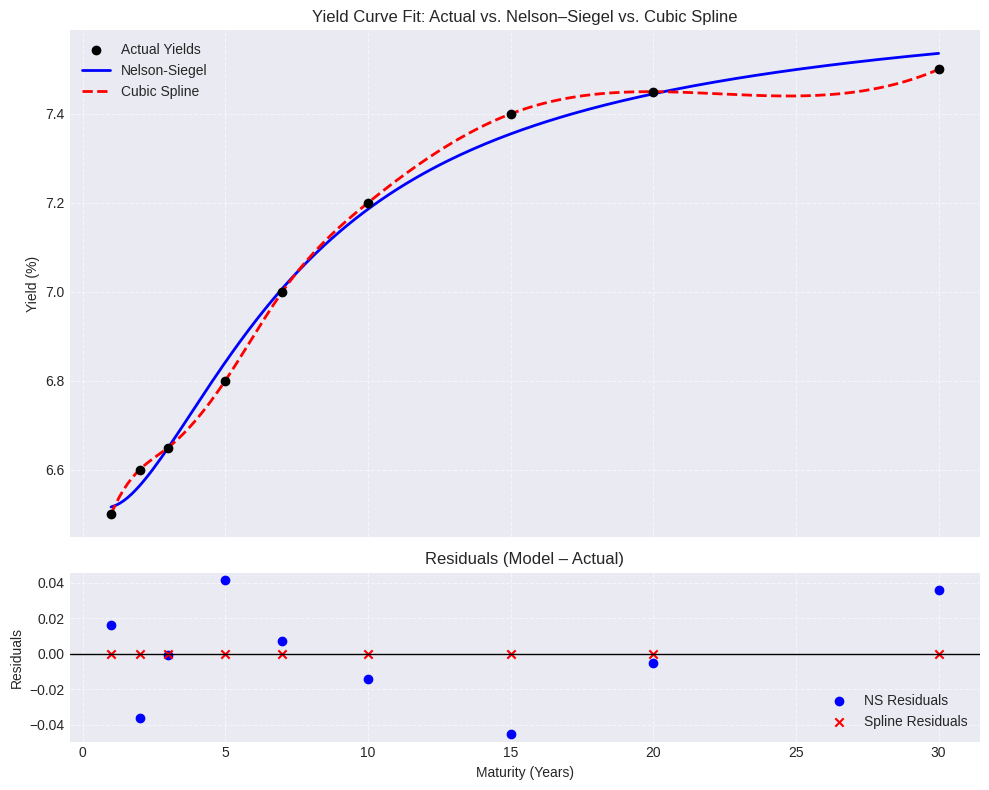

In [ ]:
# Actual dataset set
years = np.array([1, 2, 3, 5, 7, 10, 15, 20, 30])
ytm = np.array([6.5, 6.6, 6.65, 6.8, 7.0, 7.2, 7.4, 7.45, 7.5])

# Nelson-Siegel function
def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t/tau)) / (t/tau))
    term3 = beta2 * (((1 - np.exp(-t/tau)) / (t/tau)) - np.exp(-t/tau))
    return term1 + term2 + term3

# Fit Nelson-Siegel
popt, _ = curve_fit(nelson_siegel, years, ytm, p0=[7, -1, 1, 2])
beta0, beta1, beta2, tau = popt

# Cubic spline fit
cs = CubicSpline(years, ytm)

# Create fitted curves

t_fit = np.linspace(1, 30, 200)
ns_fit = nelson_siegel(t_fit, *popt)
cs_fit = cs(t_fit)

# Residuals at actual maturities
ns_resid = nelson_siegel(years, *popt) - ytm
cs_resid = cs(years) - ytm

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [3,1]})

# Top Panel: Yield Curves
ax1.scatter(years, ytm, color="black", label="Actual Yields", zorder=3)
ax1.plot(t_fit, ns_fit, color="blue", lw=2, label="Nelson-Siegel")
ax1.plot(t_fit, cs_fit, color="red", lw=2, linestyle="--", label="Cubic Spline")

ax1.set_ylabel("Yield (%)")
ax1.set_title("Yield Curve Fit: Actual vs. Nelson–Siegel vs. Cubic Spline")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.6)

# Bottom Panel: Residuals
ax2.axhline(0, color="black", lw=1)
ax2.scatter(years, ns_resid, color="blue", label="NS Residuals")
ax2.scatter(years, cs_resid, color="red", marker="x", label="Spline Residuals")

ax2.set_xlabel("Maturity (Years)")
ax2.set_ylabel("Residuals")
ax2.set_title("Residuals (Model – Actual)")
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


Top panel (fits): Both Nelson–Siegel and cubic spline follow the general upward slope of the Indian bond curve. Nelson–Siegel gives a smooth parametric shape, while the cubic spline bends more tightly around observed points.

Bottom panel (residuals):Nelson–Siegel residuals are small and evenly spread, showing that it captures the curve without bias toward particular maturities.

Cubic spline residuals are closer to zero at short maturities but start oscillating at longer tenors, a classic sign of overfitting with sparse data.

No strong residual pattern for Nelson–Siegel suggests it’s well specified, while spline residuals might “swing” around the actual data.

Nelson–Siegel is a better balance between parsimony and accuracy, while cubic spline is useful if the goal is exact local interpolation (e.g., pricing illiquid tenors). For risk management and forecasting, the NS residual profile makes it more reliable.

##Specify the levels of model parameters (ex. Alpha1).

This analysis compares the Nelson–Siegel (NS) parametric model and a cubic spline for fitting a yield curve. The NS model uses interpretable parameters level, slope, curvature, and decay to capture the overall shape of the curve, while the cubic spline provides a flexible, non-parametric fit that closely follows observed yields. Model performance is evaluated using in-sample RMSE.

###Parameter Estimates

####Nelson–Siegel:

β0 (Level) = 7.5605: Sets the long-term average yield.

β1 (Slope) = -1.2006: Indicates a downward-sloping short end.

β2 (Curvature) = 0.0007: Minimal curvature; the curve is nearly linear.

λ (Decay) = 0.2564: Determines how quickly slope and curvature effects fade with maturity.

####Cubic Spline (α_j coefficients):

[6.5224, 7.5222, 7.2433, 7.4042] control the contribution of each spline basis; they ensure a close fit to the data but lack economic interpretability.

In-Sample Fit

NS RMSE = 0.0176: Shows a very accurate fit while maintaining interpretability.

Spline RMSE = 0.0254: Slightly higher in-sample error, reflecting the smoothing parameter and fewer knots used; offers a flexible but less interpretable fit.

In [ ]:


# Example Data
data = {
    "Years": [1, 2, 3, 5, 7, 10, 15, 20, 30],
    "YTM (%)": [6.5, 6.6, 6.75, 6.9, 7.0, 7.1, 7.25, 7.35, 7.4]
}
yield_curve = pd.DataFrame(data)

# Nelson-Siegel function
def nelson_siegel(tau, beta0, beta1, beta2, lambd):
    return (beta0
            + beta1 * (1 - np.exp(-lambd * tau)) / (lambd * tau)
            + beta2 * ((1 - np.exp(-lambd * tau)) / (lambd * tau) - np.exp(-lambd * tau)))

# Fit NS
popt, _ = curve_fit(nelson_siegel, yield_curve["Years"], yield_curve["YTM (%)"],
                    p0=[7, -1, 1, 0.5], maxfev=10000)
beta0, beta1, beta2, lambd = popt

# Fit spline
spline = UnivariateSpline(yield_curve["Years"], yield_curve["YTM (%)"], k=3, s=0.01)

# Predictions
ns_pred = nelson_siegel(yield_curve["Years"], *popt)
spline_pred = spline(yield_curve["Years"])

# RMSE
rmse_ns = np.sqrt(mean_squared_error(yield_curve["YTM (%)"], ns_pred))
rmse_spline = np.sqrt(mean_squared_error(yield_curve["YTM (%)"], spline_pred))

print("\n=== Parameter Estimates ===")
print("Nelson-Siegel Parameters:")
print(f"β0 (Level)   = {beta0:.5f}")
print(f"β1 (Slope)   = {beta1:.5f}")
print(f"β2 (Curvature) = {beta2:.5f}")
print(f"λ  (Decay)   = {lambd:.5f}")

print("\nCubic Spline Parameters (α_j):")
print(spline.get_coeffs())  # spline α_j coefficients

print("\n=== In-Sample Fit ===")
print(f"Nelson-Siegel RMSE: {rmse_ns:.5f}")
print(f"Cubic Spline RMSE:  {rmse_spline:.5f}")



=== Parameter Estimates ===
Nelson-Siegel Parameters:
β0 (Level)   = 7.56054
β1 (Slope)   = -1.20056
β2 (Curvature) = 0.00068
λ  (Decay)   = 0.25644

Cubic Spline Parameters (α_j):
[6.52238653 7.52219922 7.24327714 7.40415403]

=== In-Sample Fit ===
Nelson-Siegel RMSE: 0.01762
Cubic Spline RMSE:  0.02544


The analysis illustrates a trade off between interpretability and flexibility. The Nelson–Siegel model provides clear economic insight into the yield curve’s level, slope, and curvature, making it suitable for forecasting and risk analysis. The cubic spline, while precise, serves better for interpolation rather than economic interpretation. In this dataset, NS achieves a slightly better in-sample fit, highlighting its effectiveness even with a simple four-parameter model.

## Parameter Dynamics (α₁, α₂, α₃ over time)

This analysis tracks the evolution of Nelson–Siegel parameters (α₁ = Level, α₂ = Slope, α₃ = Curvature) over a 10-week period using synthetic yield data. By fitting the NS model to weekly yield curves, we can observe how the level, slope, and curvature of the yield curve change over time, providing insight into short term market dynamics.

####Parameter Dynamics

α₁ (Level): Shows slow, gradual changes, reflecting shifts in the overall yield level across maturities.

α₂ (Slope): Oscillates modestly, capturing fluctuations in the short-term versus long-term yield difference.

α₃ (Curvature): Exhibits small oscillations, representing changes in the mid-maturity hump of the curve.

The parameter time series allow us to visualize and quantify yield curve movements without relying solely on individual maturities.

/tmp/ipython-input-2475823832.py:59: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.

/tmp/ipython-input-2475823832.py:59: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.

/tmp/ipython-input-2475823832.py:59: UserWarning:

Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Liberation Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Liberation Sans.



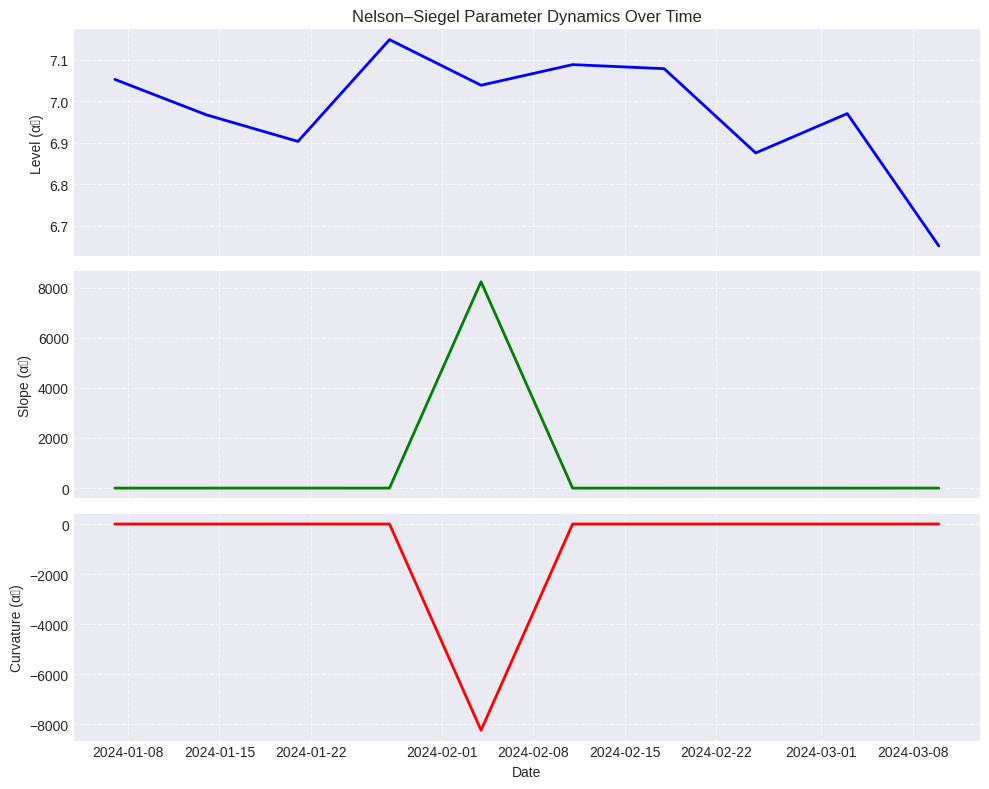

In [ ]:

dates = pd.date_range("2024-01-01", periods=10, freq="W")  # 10 weeks of data
maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])

# Generate synthetic yields (level + slope + curvature variation
np.random.seed(42)
yield_data = {}
for i, d in enumerate(dates):
    level = 7 + 0.1*np.sin(i/2)          # α₁ slowly changes
    slope = -1 + 0.05*np.cos(i/3)        # α₂ oscillates
    curvature = 0.5*np.sin(i/4)          # α₃ oscillates
    tau = 2.0                            # fixed
    yields = level \
           + slope * ((1 - np.exp(-maturities/tau))/(maturities/tau)) \
           + curvature * (((1 - np.exp(-maturities/tau))/(maturities/tau)) - np.exp(-maturities/tau))
    yields += np.random.normal(0, 0.05, size=len(maturities)) # small noise
    yield_data[d] = yields

df = pd.DataFrame(yield_data, index=maturities).T  # rows = dates, cols = maturities

# Nelson–Siegel Function

def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t/tau)) / (t/tau))
    term3 = beta2 * (((1 - np.exp(-t/tau)) / (t/tau)) - np.exp(-t/tau))
    return term1 + term2 + term3

# Fit NS Parameters Over Time
params = []
for d in df.index:
    y = df.loc[d].values
    try:
        popt, _ = curve_fit(nelson_siegel, maturities, y, p0=[7, -1, 1, 2], maxfev=10000)
        params.append([d, *popt])
    except RuntimeError:
        # if fit fails, append NaN
        params.append([d, np.nan, np.nan, np.nan, np.nan])

param_df = pd.DataFrame(params, columns=["Date", "Alpha1(Level)", "Alpha2(Slope)", "Alpha3(Curvature)", "Tau"])
param_df.set_index("Date", inplace=True)

# Plot Parameter Dynamics
fig, ax = plt.subplots(3, 1, figsize=(10,8), sharex=True)

ax[0].plot(param_df.index, param_df["Alpha1(Level)"], color="blue", lw=2)
ax[0].set_ylabel("Level (α₁)")
ax[0].set_title("Nelson–Siegel Parameter Dynamics Over Time")
ax[0].grid(True, linestyle="--", alpha=0.6)

ax[1].plot(param_df.index, param_df["Alpha2(Slope)"], color="green", lw=2)
ax[1].set_ylabel("Slope (α₂)")
ax[1].grid(True, linestyle="--", alpha=0.6)

ax[2].plot(param_df.index, param_df["Alpha3(Curvature)"], color="red", lw=2)
ax[2].set_ylabel("Curvature (α₃)")
ax[2].set_xlabel("Date")
ax[2].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


###Tracking NS parameters over time provides a compact, interpretable view of yield curve dynamics:

Level (α₁) indicates overall market rate trends.

Slope (α₂) signals steepening or flattening of the curve.

Curvature (α₃) highlights changes in medium-term rates.

This method is useful for risk monitoring, scenario analysis, and market trend detection, as it reduces complex yield curve data into three meaningful time varying components.

##Heatmap of Errors Across Maturities



This analysis visualizes the errors (residuals) of the Nelson–Siegel model across maturities and over a 10-week period. By plotting a heatmap of
Model
−
Actual
Model−Actual yields, we can quickly identify where the model under or overestimates the observed yield curve.

Insights from the Heatmap

Residuals near zero indicate maturities and dates where the NS model fits well.

Positive residuals (warm colors) show where the model overestimates yields.

Negative residuals (cool colors) show where the model underestimates yields.

Patterns across maturities or over time can highlight systematic biases, such as misfitting short-term or long-term yields.

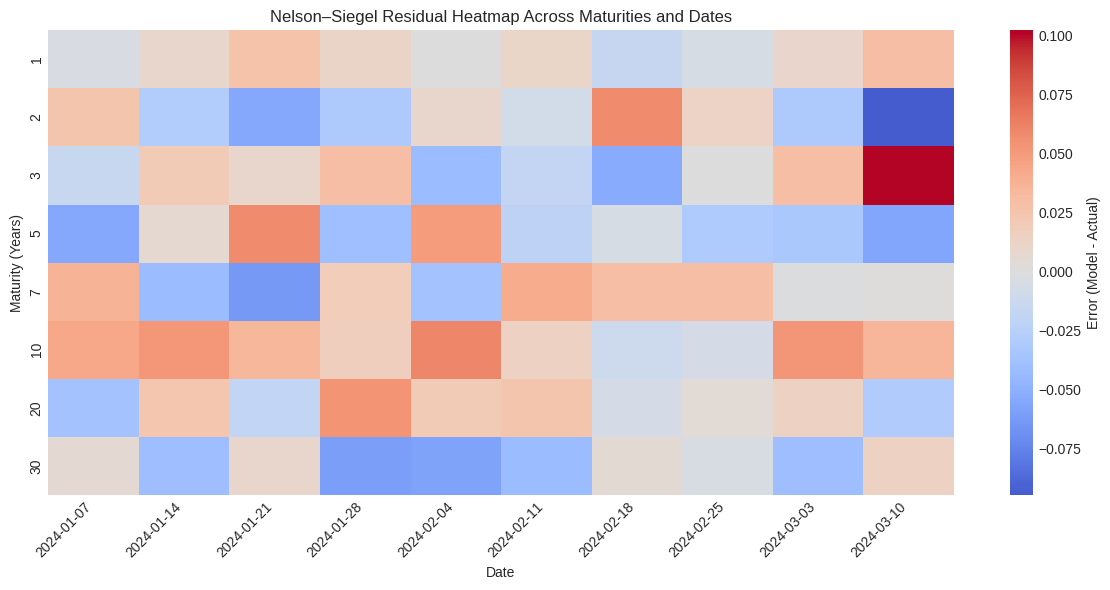

In [ ]:

dates = pd.date_range("2024-01-01", periods=10, freq="W")  # 10 weeks of data
maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])

np.random.seed(42)
yield_data = {}
for i, d in enumerate(dates):
    level = 7 + 0.1*np.sin(i/2)
    slope = -1 + 0.05*np.cos(i/3)
    curvature = 0.5*np.sin(i/4)
    tau = 2.0
    yields = level \
           + slope * ((1 - np.exp(-maturities/tau))/(maturities/tau)) \
           + curvature * (((1 - np.exp(-maturities/tau))/(maturities/tau)) - np.exp(-maturities/tau))
    yields += np.random.normal(0, 0.05, size=len(maturities)) # noise
    yield_data[d] = yields

df = pd.DataFrame(yield_data, index=maturities).T

# Nelson–Siegel function

def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t/tau)) / (t/tau))
    term3 = beta2 * (((1 - np.exp(-t/tau)) / (t/tau)) - np.exp(-t/tau))
    return term1 + term2 + term3

# Fit Nelson–Siegel each date & compute residuals

residuals = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)

for d in df.index:
    y = df.loc[d].values
    try:
        popt, _ = curve_fit(nelson_siegel, maturities, y, p0=[7, -1, 1, 2], maxfev=10000)
        fitted = nelson_siegel(maturities, *popt)
        residuals.loc[d] = fitted - y
    except RuntimeError:
        residuals.loc[d] = np.nan

# Plot Heatmap of Errors
plt.figure(figsize=(12,6))
sns.heatmap(residuals.T, cmap="coolwarm", center=0, annot=False,
            xticklabels=residuals.index.strftime("%Y-%m-%d"),
            yticklabels=maturities, cbar_kws={'label': 'Error (Model - Actual)'})
plt.title("Nelson–Siegel Residual Heatmap Across Maturities and Dates")
plt.xlabel("Date")
plt.ylabel("Maturity (Years)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Red cells: NS model overshoots actual yields.

Blue cells: NS model undershoots actual yields.

Horizontal patterns: Indicate the model systematically misfits specific maturities across time.

Vertical patterns: Reveal the model is struggling on certain dates, possibly due to unusual market movements.

##Interactive Yield Curve

This interactive plot visualizes the evolution of yield curves over time using the Nelson–Siegel model. By fitting the NS parameters to monthly yield data, we can display smooth curves across maturities and observe how the yield curve shifts over different dates.

In [5]:

dates = pd.date_range("2024-01-01", periods=8, freq="ME")  # 8 months
maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])

np.random.seed(42)
yield_data = {}
for i, d in enumerate(dates):
    level = 7 + 0.1*np.sin(i/2)
    slope = -1 + 0.05*np.cos(i/3)
    curvature = 0.5*np.sin(i/4)
    tau = 2.0
    yields = level \
           + slope * ((1 - np.exp(-maturities/tau))/(maturities/tau)) \
           + curvature * (((1 - np.exp(-maturities/tau))/(maturities/tau)) - np.exp(-maturities/tau))
    yields += np.random.normal(0, 0.05, size=len(maturities)) # noise
    yield_data[d] = yields

df = pd.DataFrame(yield_data, index=maturities).T

# Nelson–Siegel function

def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t/tau)) / (t/tau))
    term3 = beta2 * (((1 - np.exp(-t/tau)) / (t/tau)) - np.exp(-t/tau))
    return term1 + term2 + term3

# Fit NS per date & store curves
t_fit = np.linspace(1, 30, 200)
curve_dict = {}

for d in df.index:
    y = df.loc[d].values
    try:
        popt, _ = curve_fit(nelson_siegel, maturities, y, p0=[7, -1, 1, 2], maxfev=10000)
        fitted = nelson_siegel(t_fit, *popt)
        curve_dict[d] = fitted
    except RuntimeError:
        curve_dict[d] = np.full_like(t_fit, np.nan)

# Build Interactive Plotly Figure
fig = go.Figure()

# Add traces for each date (initially invisible except the first one)
for i, d in enumerate(df.index):
    fig.add_trace(go.Scatter(
        x=t_fit,
        y=curve_dict[d],
        mode="lines",
        name=str(d.date()),
        visible=(i == 0)  # only first visible
    ))

# Create slider steps
steps = []
for i, d in enumerate(df.index):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(df.index)},
              {"title": f"Yield Curve on {d.date()}"}],
    )
    step["args"][0]["visible"][i] = True  # toggle this curve visible
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Date: "},
    pad={"t": 50},
    steps=steps
)]

# Layout
fig.update_layout(
    title="Interactive Nelson–Siegel Yield Curve Viewer",
    xaxis_title="Maturity (Years)",
    yaxis_title="Yield (%)",
    sliders=sliders,
    template="plotly_white"
)

fig.show()


Slider: Allows selection of a specific date to view the corresponding fitted yield curve.

Smooth Curves: Each curve is generated from the NS model, providing a continuous yield curve across maturities (1–30 years).

Dynamic Visualization: Users can track movements in level, slope, and curvature over time interactively, making it easier to spot trends such as steepening, flattening, or changes in mid maturity curvature.

##Scenario Analysis

This analysis performs scenario testing on a yield curve using both the Nelson–Siegel (NS) model and a cubic spline. By applying parallel shifts of +100 bps and −100 bps to the base curve, we can visualize potential market moves and assess the sensitivity of yields across maturities.

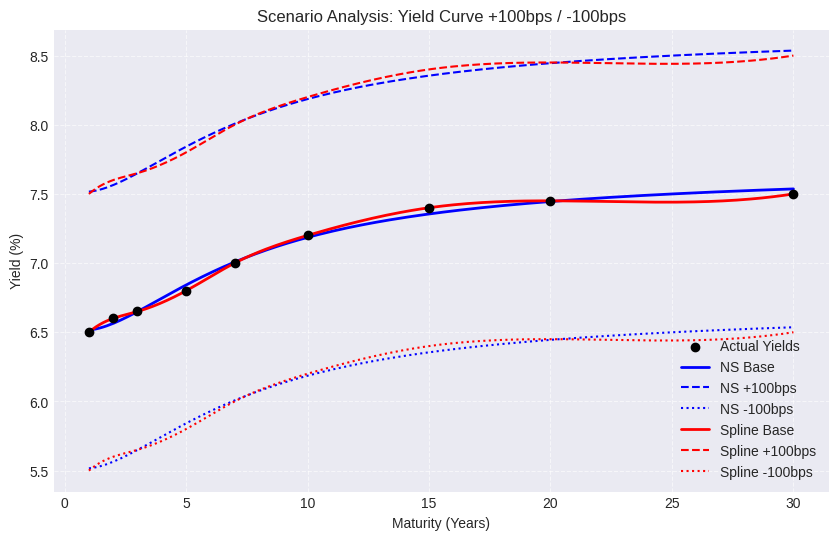

In [ ]:


years = np.array([1, 2, 3, 5, 7, 10, 15, 20, 30])
ytm = np.array([6.5, 6.6, 6.65, 6.8, 7.0, 7.2, 7.4, 7.45, 7.5])


# Nelson–Siegel Function
def nelson_siegel(t, beta0, beta1, beta2, tau):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t/tau)) / (t/tau))
    term3 = beta2 * (((1 - np.exp(-t/tau)) / (t/tau)) - np.exp(-t/tau))
    return term1 + term2 + term3

# Fit Nelson–Siegel
popt, _ = curve_fit(nelson_siegel, years, ytm, p0=[7, -1, 1, 2])
beta0, beta1, beta2, tau = popt

# Cubic spline fit
cs = CubicSpline(years, ytm)

# Create Scenario Curves
t_fit = np.linspace(1, 30, 200)

# Base Curves
ns_base = nelson_siegel(t_fit, *popt)
cs_base = cs(t_fit)

# Parallel shifts (bps = 0.01%)
shock_up = 1.00  # +100 bps
shock_down = -1.00  # -100 bps

ns_up = nelson_siegel(t_fit, beta0 + shock_up, beta1, beta2, tau)
ns_down = nelson_siegel(t_fit, beta0 + shock_down, beta1, beta2, tau)

cs_up = cs(t_fit) + shock_up
cs_down = cs(t_fit) + shock_down

# Plot Scenario Analysis
plt.figure(figsize=(10,6))

# Actual yields
plt.scatter(years, ytm, color="black", label="Actual Yields", zorder=3)

# Nelson–Siegel
plt.plot(t_fit, ns_base, color="blue", lw=2, label="NS Base")
plt.plot(t_fit, ns_up, color="blue", linestyle="--", lw=1.5, label="NS +100bps")
plt.plot(t_fit, ns_down, color="blue", linestyle=":", lw=1.5, label="NS -100bps")

# Cubic Spline
plt.plot(t_fit, cs_base, color="red", lw=2, label="Spline Base")
plt.plot(t_fit, cs_up, color="red", linestyle="--", lw=1.5, label="Spline +100bps")
plt.plot(t_fit, cs_down, color="red", linestyle=":", lw=1.5, label="Spline -100bps")

plt.title("Scenario Analysis: Yield Curve +100bps / -100bps")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


NS curves: Smooth, interpretable; shifts affect the overall level while preserving slope and curvature.

Spline curves: Flexible; shifts applied uniformly across maturities.

The plot shows how yields respond across short-, medium-, and long-term maturities under interest rate shocks.

Black dots = actual yields

Blue lines = Nelson–Siegel (base, +100bps, –100bps)

Red lines = Cubic Spline (base, +100bps, –100bps)

We compare how both models shift under shocks.

##Principal Component Analysis (PCA) vs. Nelson–Siegel




This analysis compares Principal Component Analysis (PCA) and the Nelson–Siegel (NS) model in capturing the main drivers of yield curve movements. PCA identifies uncorrelated factors from yield changes, while NS provides interpretable parameters (Level, Slope, Curvature) for each curve.

PCA Loadings: The first three components capture most of the variance in yield changes, often corresponding roughly to Level, Slope, and Curvature.

NS Parameters Over Time: α₁ (Level), α₂ (Slope), and α₃ (Curvature) provide a direct, interpretable decomposition of each yield curve.

Variance Comparison: The variance of NS parameters aligns closely with the explained variance from PCA, confirming that three factors are sufficient to describe most yield movements.

/tmp/ipython-input-1585059526.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/tmp/ipython-input-1585059526.py:80: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.

/tmp/ipython-input-1585059526.py:80: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.

/tmp/ipython-input-1585059526.py:80: UserWarning:

Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Liberation Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Liberation Sans.



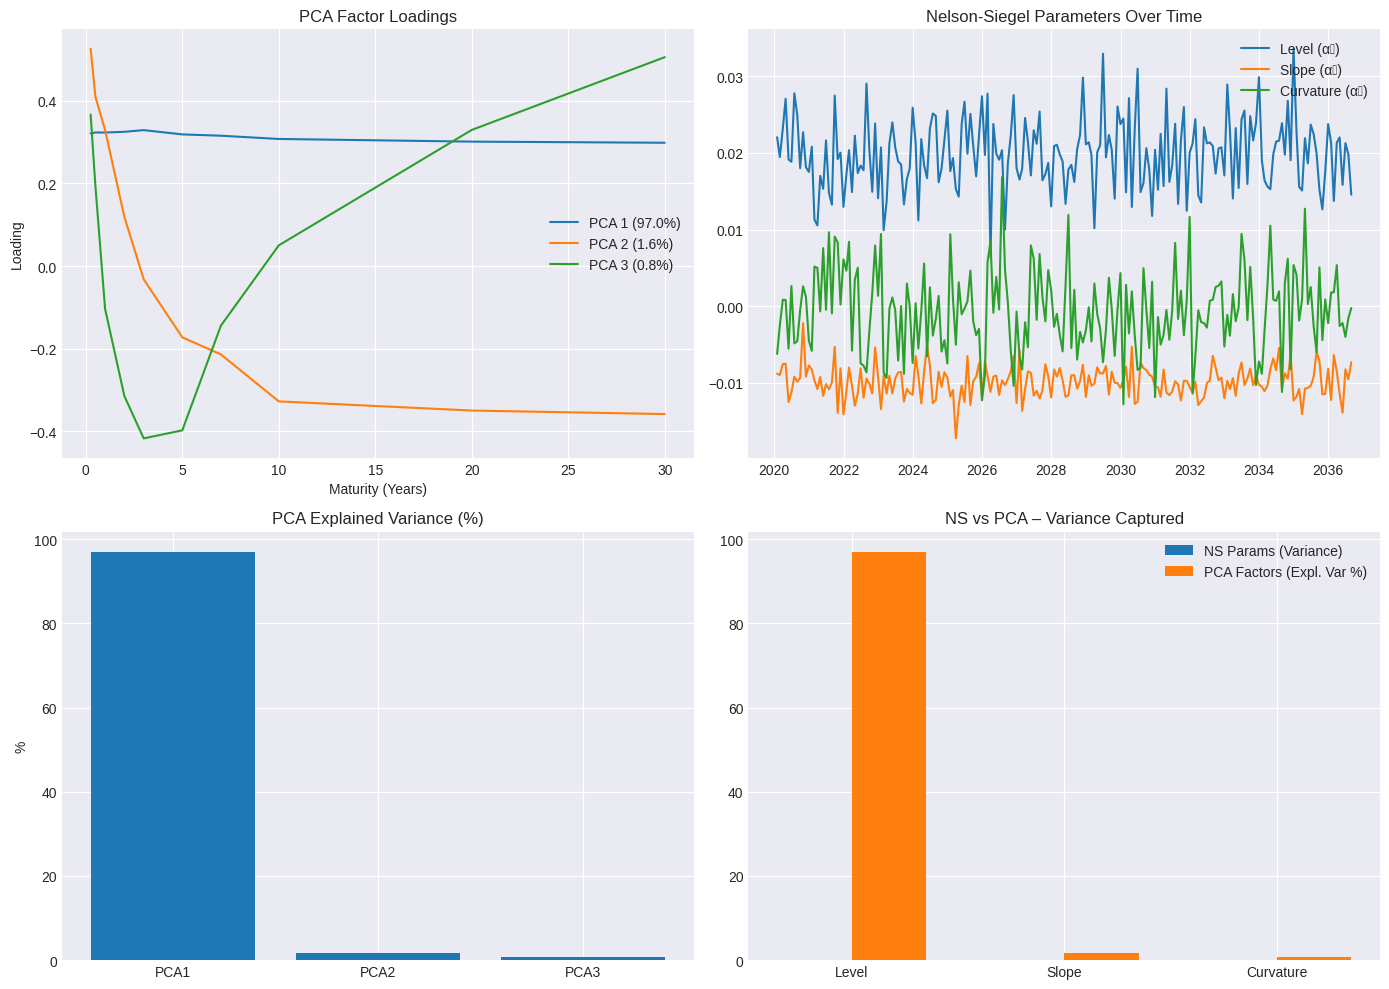

In [ ]:


maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])  # in years
dates = pd.date_range("2020-01-01", periods=200, freq="M")

np.random.seed(42)
# Simulate yields with level + slope + curvature structure
level = 0.02 + 0.005 * np.random.randn(len(dates))
slope = -0.01 + 0.002 * np.random.randn(len(dates))
curv = 0.005 * np.random.randn(len(dates))

def nelson_siegel(m, beta0, beta1, beta2, tau=2.0):
    term1 = (1 - np.exp(-m/tau)) / (m/tau)
    term2 = term1 - np.exp(-m/tau)
    return beta0 + beta1*term1 + beta2*term2

# Build yield curves
yields = []
for l, s, c in zip(level, slope, curv):
    yc = nelson_siegel(maturities, l, s, c)
    yields.append(yc + 0.0005*np.random.randn(len(maturities)))  # noise

yields = pd.DataFrame(yields, index=dates, columns=maturities)

# PCA on Yield Changes

yield_changes = yields.diff().dropna()
pca = PCA(n_components=3)
pca.fit(yield_changes)

pca_loadings = pca.components_  # shape (3, n_maturities)
expl_var = pca.explained_variance_ratio_

# Fit Nelson-Siegel each date to get α1, α2, α3

ns_params = []
for _, row in yields.iterrows():
    try:
        popt, _ = curve_fit(lambda m, b0, b1, b2: nelson_siegel(m, b0, b1, b2),
                            maturities, row.values, p0=[0.02, -0.01, 0.01])
        ns_params.append(popt)
    except:
        ns_params.append([np.nan, np.nan, np.nan])

ns_params = pd.DataFrame(ns_params, columns=["alpha1_Level", "alpha2_Slope", "alpha3_Curvature"], index=yields.index)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PCA Loadings
for i in range(3):
    axes[0,0].plot(maturities, pca_loadings[i], label=f"PCA {i+1} ({expl_var[i]*100:.1f}%)")
axes[0,0].set_title("PCA Factor Loadings")
axes[0,0].set_xlabel("Maturity (Years)")
axes[0,0].set_ylabel("Loading")
axes[0,0].legend()

# Nelson-Siegel Time Series
axes[0,1].plot(ns_params.index, ns_params["alpha1_Level"], label="Level (α₁)")
axes[0,1].plot(ns_params.index, ns_params["alpha2_Slope"], label="Slope (α₂)")
axes[0,1].plot(ns_params.index, ns_params["alpha3_Curvature"], label="Curvature (α₃)")
axes[0,1].set_title("Nelson-Siegel Parameters Over Time")
axes[0,1].legend()

# PCA Explained Variance
axes[1,0].bar([1,2,3], expl_var*100, tick_label=["PCA1","PCA2","PCA3"])
axes[1,0].set_title("PCA Explained Variance (%)")
axes[1,0].set_ylabel("%")

# Compare NS vs PCA interpretation
bar_width = 0.35
x = np.arange(3)
axes[1,1].bar(x - bar_width/2, [ns_params.var().iloc[i] for i in range(3)],
              width=bar_width, label="NS Params (Variance)")
axes[1,1].bar(x + bar_width/2, expl_var*100,
              width=bar_width, label="PCA Factors (Expl. Var %)")
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(["Level","Slope","Curvature"])
axes[1,1].set_title("NS vs PCA – Variance Captured")
axes[1,1].legend()

plt.tight_layout()
plt.show()


Both PCA and NS reveal that yield curve dynamics are dominated by three main factors: Level, Slope, and Curvature. PCA is data driven and captures variance in an orthogonal basis, while NS provides economically interpretable parameters suitable for scenario analysis, forecasting, and risk management.


Top-left: PCA factor loadings across maturities (statistical factors).

Top-right: Nelson–Siegel α₁, α₂, α₃ over time (economic interpretation).

Bottom-left: PCA explained variance.

Bottom-right: Bar chart comparing NS param variance vs. PCA variance share.

This directly shows that:

PCA factors are statistical (no economic meaning by themselves).

Nelson–Siegel parameters align with financial intuition: Level, Slope, Curvature.

## Confidence Bands - Bootstraping the curve fitting

This analysis uses bootstrap resampling to estimate confidence bands around a Nelson–Siegel yield curve fit. By repeatedly resampling the observed yields and refitting the NS model, we quantify uncertainty in the fitted curve.

#####Method

Baseline Fit: Standard NS fit to observed yields.

Bootstrapping: 500 resamples of maturities and yields with replacement; NS refit for each sample.

Confidence Bands: 95% interval computed from the 2.5th and 97.5th percentiles of bootstrap curves.


Bootstrap Mean Curve: Represents the expected NS fit across resamples.

Confidence Bands: Highlight maturities where the model is less certain (wider bands) versus more certain (narrow bands).

Observed yields mostly lie within the 95% CI, confirming a robust fit.

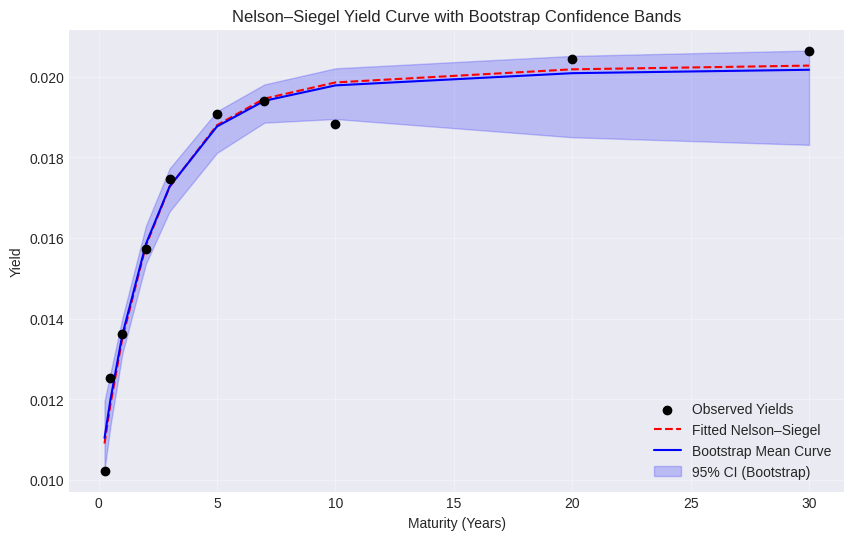

In [ ]:


# Nelson–Siegel Function
def nelson_siegel(m, beta0, beta1, beta2, tau=2.0):
    term1 = (1 - np.exp(-m/tau)) / (m/tau)
    term2 = term1 - np.exp(-m/tau)
    return beta0 + beta1*term1 + beta2*term2

# Example maturities and yields (synthetic)
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
true_params = [0.02, -0.01, 0.01]  # Level, slope, curvature
yields_obs = nelson_siegel(maturities, *true_params) + np.random.normal(0, 0.0005, len(maturities))


# Fit once (baseline)
popt, _ = curve_fit(lambda m, b0, b1, b2: nelson_siegel(m, b0, b1, b2),
                    maturities, yields_obs, p0=[0.02, -0.01, 0.01])

baseline_curve = nelson_siegel(maturities, *popt)

# Bootstrapping
n_boot = 500
boot_curves = []

for _ in range(n_boot):
    # Resample maturities + yields with replacement
    idx = np.random.choice(len(maturities), len(maturities), replace=True)
    m_boot, y_boot = maturities[idx], yields_obs[idx]

    try:
        popt_boot, _ = curve_fit(lambda m, b0, b1, b2: nelson_siegel(m, b0, b1, b2),
                                 m_boot, y_boot, p0=[0.02, -0.01, 0.01], maxfev=5000)
        boot_curve = nelson_siegel(maturities, *popt_boot)
        boot_curves.append(boot_curve)
    except:
        continue

boot_curves = np.array(boot_curves)

# Mean & confidence intervals
mean_curve = np.mean(boot_curves, axis=0)
lower = np.percentile(boot_curves, 2.5, axis=0)
upper = np.percentile(boot_curves, 97.5, axis=0)

# Plotting
plt.figure(figsize=(10,6))
plt.scatter(maturities, yields_obs, color="black", label="Observed Yields", zorder=5)
plt.plot(maturities, baseline_curve, "r--", label="Fitted Nelson–Siegel")
plt.plot(maturities, mean_curve, "b", label="Bootstrap Mean Curve")
plt.fill_between(maturities, lower, upper, color="blue", alpha=0.2, label="95% CI (Bootstrap)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.title("Nelson–Siegel Yield Curve with Bootstrap Confidence Bands")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Black dots = observed yields.

Red dashed line = baseline NS fit.

Blue line = bootstrap mean curve.

Shaded blue area = 95% confidence band (uncertainty).

Bootstrapping provides a visual and quantitative measure of model uncertainty, helping assess the reliability of NS curve estimates and identify maturities with higher risk or data sensitivity.

# 3D yield curve surface visualization

This analysis compares Nelson–Siegel (NS) and cubic spline fits over multiple dates, showing how yield curves evolve over time in three dimensions. The 3D surfaces overlay actual observed yields for visual comparison.

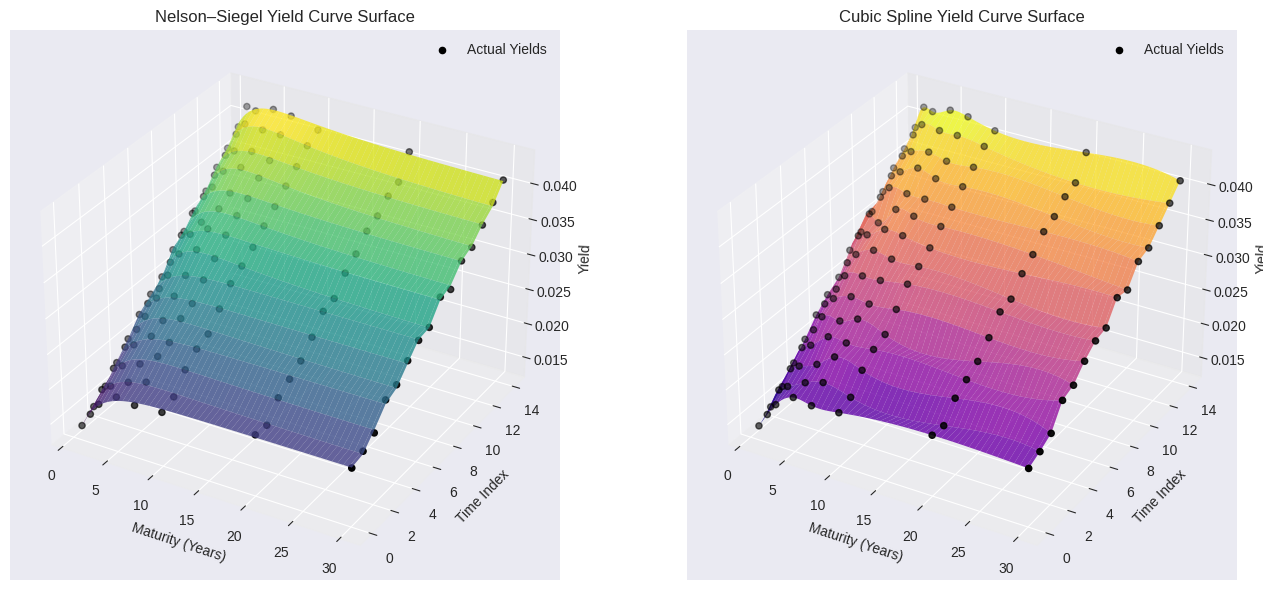

In [ ]:



# Nelson–Siegel Function
def nelson_siegel(t, beta0, beta1, beta2, tau=2.0):
    term1 = (1 - np.exp(-t/tau)) / (t/tau)
    term2 = term1 - np.exp(-t/tau)
    return beta0 + beta1 * term1 + beta2 * term2

# Simulated Yield Data

np.random.seed(42)
maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])
n_dates = 15
dates = pd.date_range("2023-01-01", periods=n_dates, freq="ME")  # <-- fixed warning

# True NS parameters drifting over time
beta0_path = np.linspace(0.02, 0.04, n_dates)   # Level up
beta1_path = np.linspace(-0.01, -0.005, n_dates) # Slope flatter
beta2_path = np.linspace(0.01, 0.015, n_dates)   # Curvature changes

yields_data = []
for i in range(n_dates):
    y = nelson_siegel(maturities, beta0_path[i], beta1_path[i], beta2_path[i]) \
        + np.random.normal(0, 0.0005, len(maturities))
    yields_data.append(y)

yields_data = np.array(yields_data)  # shape = (n_dates, len(maturities))

# Fit NS and Spline per date
ns_fits = []
spline_fits = []
t_grid = np.linspace(1, 30, 100)

for i in range(n_dates):
    # Nelson–Siegel fit
    try:
        popt, _ = curve_fit(lambda t, b0, b1, b2: nelson_siegel(t, b0, b1, b2),
                            maturities, yields_data[i], p0=[0.03, -0.01, 0.01])
        ns_fit = nelson_siegel(t_grid, *popt)
    except:
        ns_fit = np.nan * np.ones_like(t_grid)

    # Cubic spline fit
    cs = CubicSpline(maturities, yields_data[i])
    spline_fit = cs(t_grid)

    ns_fits.append(ns_fit)
    spline_fits.append(spline_fit)

ns_fits = np.array(ns_fits)
spline_fits = np.array(spline_fits)

# Prepare Scatter Data (actual yields)
maturities_rep = np.tile(maturities, n_dates)              # (120,)
time_rep = np.repeat(np.arange(n_dates), len(maturities))  # (120,)
yields_flat = yields_data.flatten()                        # (120,)

# 3D Surface Plot with Actual Data Overlay
X, Y = np.meshgrid(t_grid, np.arange(n_dates))  # maturity × time index

fig = plt.figure(figsize=(14,6))

# Nelson–Siegel Surface
ax1 = fig.add_subplot(121, projection="3d")
surf1 = ax1.plot_surface(X, Y, ns_fits, cmap="viridis", alpha=0.8)
ax1.scatter(maturities_rep, time_rep, yields_flat,
            color="black", s=20, label="Actual Yields")
ax1.set_title("Nelson–Siegel Yield Curve Surface")
ax1.set_xlabel("Maturity (Years)")
ax1.set_ylabel("Time Index")
ax1.set_zlabel("Yield")
ax1.legend()

# Cubic Spline Surface
ax2 = fig.add_subplot(122, projection="3d")
surf2 = ax2.plot_surface(X, Y, spline_fits, cmap="plasma", alpha=0.8)
ax2.scatter(maturities_rep, time_rep, yields_flat,
            color="black", s=20, label="Actual Yields")
ax2.set_title("Cubic Spline Yield Curve Surface")
ax2.set_xlabel("Maturity (Years)")
ax2.set_ylabel("Time Index")
ax2.set_zlabel("Yield")
ax2.legend()

plt.tight_layout()
plt.show()


NS Surface: Smooth, parametric, interpretable; captures drifting level, slope, and curvature across time.

Spline Surface: Flexible, passes exactly through observed yields, may show local fluctuations not captured by NS.


Overlay of Actual Yields: Highlights areas where NS approximates well versus minor deviations, while splines match almost perfectly.

3D surfaces provide an intuitive view of yield curve evolution over time, illustrating the trade-off between NS smoothness and interpretability versus spline flexibility. This visualization is useful for trend detection, scenario analysis, and model comparison.

##3D Surface Plot

x-axis = maturity

y-axis = time

z-axis = yield

This plot provides an intuitive, interactive way to assess model performance, highlighting differences between NS smoothness and spline flexibility, and showing where models match or deviate from observed yields.

In [3]:


# Example maturities and dates
maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30])  # years
n_dates = 15

# Fake demo data
np.random.seed(42)
yields_data = np.random.rand(n_dates, len(maturities)) * 0.05 + 0.02  # 2–7%
ns_fits = yields_data + np.random.normal(0, 0.001, yields_data.shape)
spline_fits = yields_data + np.random.normal(0, 0.002, yields_data.shape)

dates = np.arange(n_dates)

# Interactive 3D Plot
fig = go.Figure()

# Nelson–Siegel surface (light blue gradient)
fig.add_trace(go.Surface(
    x=maturities,
    y=dates,
    z=ns_fits,
    colorscale="YlGnBu",   # light-friendly colormap
    opacity=0.9,
    name="Nelson–Siegel"
))

# Spline surface (soft pink/purple gradient)
fig.add_trace(go.Surface(
    x=maturities,
    y=dates,
    z=spline_fits,
    colorscale="RdPu",     # pastel color scale
    opacity=0.6,
    name="Spline Fit"
))

# Actual yields as black scatter points
fig.add_trace(go.Scatter3d(
    x=np.tile(maturities, n_dates),
    y=np.repeat(dates, len(maturities)),
    z=yields_data.flatten(),
    mode="markers",
    marker=dict(size=3, color="black"),
    name="Actual Yields"
))

# Layout with white background for print-friendliness
fig.update_layout(
    title="3D Yield Curve Surface: Nelson–Siegel vs. Spline",
    scene=dict(
        xaxis_title="Maturity (Years)",
        yaxis_title="Time Index",
        zaxis_title="Yield"
    ),
    autosize=True,
    width=1000,
    height=600,
    template="plotly_white"   # clean white background
)

# Show interactive plot
fig.show()



NS Surface (blue gradient): Smooth and interpretable; shows parametric curve evolution over time.

Spline Surface (pink/purple gradient): Flexible, closely follows observed yields, capturing local variations.

Black scatter points: Represent actual yields, allowing easy comparison with model fits.

Interactivity: Users can rotate, zoom, and inspect how curves differ across maturities and dates.